In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from scipy.sparse import csr_matrix
from math import log2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score, average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score
from scipy.stats import uniform, randint
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import HashingVectorizer
from collections import defaultdict
import time
import torch
import warnings
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm
import pickle

### Этап 1: Загрузка и предобработка данных ###
##### Загрузка данных из Kaggle #####

In [2]:
# Используем kagglehub для загрузки датасета
path = kagglehub.dataset_download("frtgnn/dunnhumby-the-complete-journey")
print("Path to dataset files:", path)

# Пытаемся загрузить все CSV-файлы в датафреймы
try:
    campaign_desc = pd.read_csv(path + "/" + "campaign_desc.csv")
    campaign_table = pd.read_csv(path + "/" + "campaign_table.csv")
    causal_data = pd.read_csv(path + "/" + "causal_data.csv")
    coupon_redempt = pd.read_csv(path + "/" + "coupon_redempt.csv")
    coupon = pd.read_csv(path + "/" + "coupon.csv")
    hh_demographic = pd.read_csv(path + "/" + "hh_demographic.csv")
    product = pd.read_csv(path + "/" + "product.csv")
    transaction_data = pd.read_csv(path + "/" + "transaction_data.csv")
    print("Все файлы успешно загружены в pandas.")
except FileNotFoundError as e:
    print(f"Ошибка: Не удалось найти файл {e.filename}.")
    exit()

Path to dataset files: /kaggle/input/dunnhumby-the-complete-journey
Все файлы успешно загружены в pandas.


##### Объединение транзакций и продуктов #####

In [3]:
# Агрегируем транзакции по household_key и PRODUCT_ID, сохраняем DAY
aggregated_transactions = transaction_data.groupby(['household_key', 'PRODUCT_ID']).agg({
    'QUANTITY': 'sum',
    'SALES_VALUE': 'sum',
    'DAY': 'max'  # Сохраняем самую позднюю дату покупки
}).reset_index()

# Объединяем транзакции с информацией о продуктах и демографией домохозяйств
combined_data = pd.merge(aggregated_transactions, product, on='PRODUCT_ID', how='left')
combined_data = pd.merge(combined_data, hh_demographic, on='household_key', how='left')

# Удаляем ненужную колонку
combined_data = combined_data.drop('CURR_SIZE_OF_PRODUCT', axis=1)

In [4]:
# Посмотрим описательную статистику
combined_data.describe()


,household_key,PRODUCT_ID,QUANTITY,SALES_VALUE,DAY,MANUFACTURER
count,1.401469e+06,1.401469e+06,1.401469e+06,1.401469e+06,1.401469e+06,1.401469e+06
mean,1.274187e+03,3.286085e+06,1.860088e+02,5.749298e+00,4.166882e+02,1.103979e+03
std,7.265707e+02,4.236226e+06,1.043783e+04,2.804446e+01,1.955026e+02,1.415479e+03
min,1.000000e+00,2.567100e+04,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,6.530000e+02,9.203090e+05,1.000000e+00,1.670000e+00,2.540000e+02,6.900000e+01
50%,1.272000e+03,1.034316e+06,1.000000e+00,2.790000e+00,4.320000e+02,6.730000e+02
75%,1.917000e+03,5.568661e+06,2.000000e+00,5.000000e+00,5.930000e+02,1.377000e+03
max,2.500000e+03,1.831630e+07,3.742401e+06,9.444060e+03,7.110000e+02,6.477000e+03


##### Проведем обработку пропусков и дубликатов #####

In [5]:
# Реализуем функцию
def preprocess_data(df):
    num_null = df.isnull().sum().sum()
    num_duplicates = df.duplicated().sum()

    if num_null > 0 or num_duplicates > 0:
        print(f"Проверка данных:")
        print(f" Количество пропусков до обработки:\n{df.isnull().sum()}")
        print(f" Количество дубликатов до обработки: {df.duplicated().sum()}")

        # Заполнение пропусков (заполняем 'Unknown' для категориальных признаков и 0 для числовых)
        for col in df.columns:
            if df[col].dtype == "object":
                df[col] = df[col].fillna("Unknown")
            else:
                df[col] = df[col].fillna(0)

        if num_duplicates > 0:
            print(f"Удаление дубликатов...")
            df.drop_duplicates(inplace=True)

        print(f"  Количество пропусков после обработки:\n{df.isnull().sum()}")
        print(f"  Количество дубликатов после обработки: {df.duplicated().sum()}")

    else:
        print(f"Пропуски и дубликаты не найдены.")


In [6]:
# Запустим функцию
preprocess_data(combined_data)

Проверка данных:
 Количество пропусков до обработки:
household_key               0
PRODUCT_ID                  0
QUANTITY                    0
SALES_VALUE                 0
DAY                         0
MANUFACTURER                0
DEPARTMENT                  0
BRAND                       0
COMMODITY_DESC              0
SUB_COMMODITY_DESC          0
AGE_DESC               696108
MARITAL_STATUS_CODE    696108
INCOME_DESC            696108
HOMEOWNER_DESC         696108
HH_COMP_DESC           696108
HOUSEHOLD_SIZE_DESC    696108
KID_CATEGORY_DESC      696108
dtype: int64
 Количество дубликатов до обработки: 0
  Количество пропусков после обработки:
household_key          0
PRODUCT_ID             0
QUANTITY               0
SALES_VALUE            0
DAY                    0
MANUFACTURER           0
DEPARTMENT             0
BRAND                  0
COMMODITY_DESC         0
SUB_COMMODITY_DESC     0
AGE_DESC               0
MARITAL_STATUS_CODE    0
INCOME_DESC            0
HOMEOWNER_DESC      

In [7]:
# Выводим финальный размер датасета
print("Размер датасета после предобработки:", combined_data.shape)

Размер датасета после предобработки: (1401469, 17)


In [8]:
combined_data.head()

,household_key,PRODUCT_ID,QUANTITY,SALES_VALUE,DAY,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,1,819312,1,5.67,536,3262,DRUG GM,National,IN-STORE PHOTOFINISHING,ONE HOUR PROCESSING,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
1,1,820165,11,5.50,706,2,PRODUCE,National,CITRUS,ORANGES NAVELS ALL,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,1,821815,2,3.38,311,131,GROCERY,National,DRY SAUCES/GRAVY,GRAVY CAN/GLASS,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
3,1,821867,1,0.69,639,61,GROCERY,National,BAKING NEEDS,BAKING CUPS,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
4,1,823721,1,2.99,291,317,GROCERY,National,CHEESE,GRATED CHEESE,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown


### Этап 2: EDA (Разведка) ###
##### Анализ клиентской базы #####

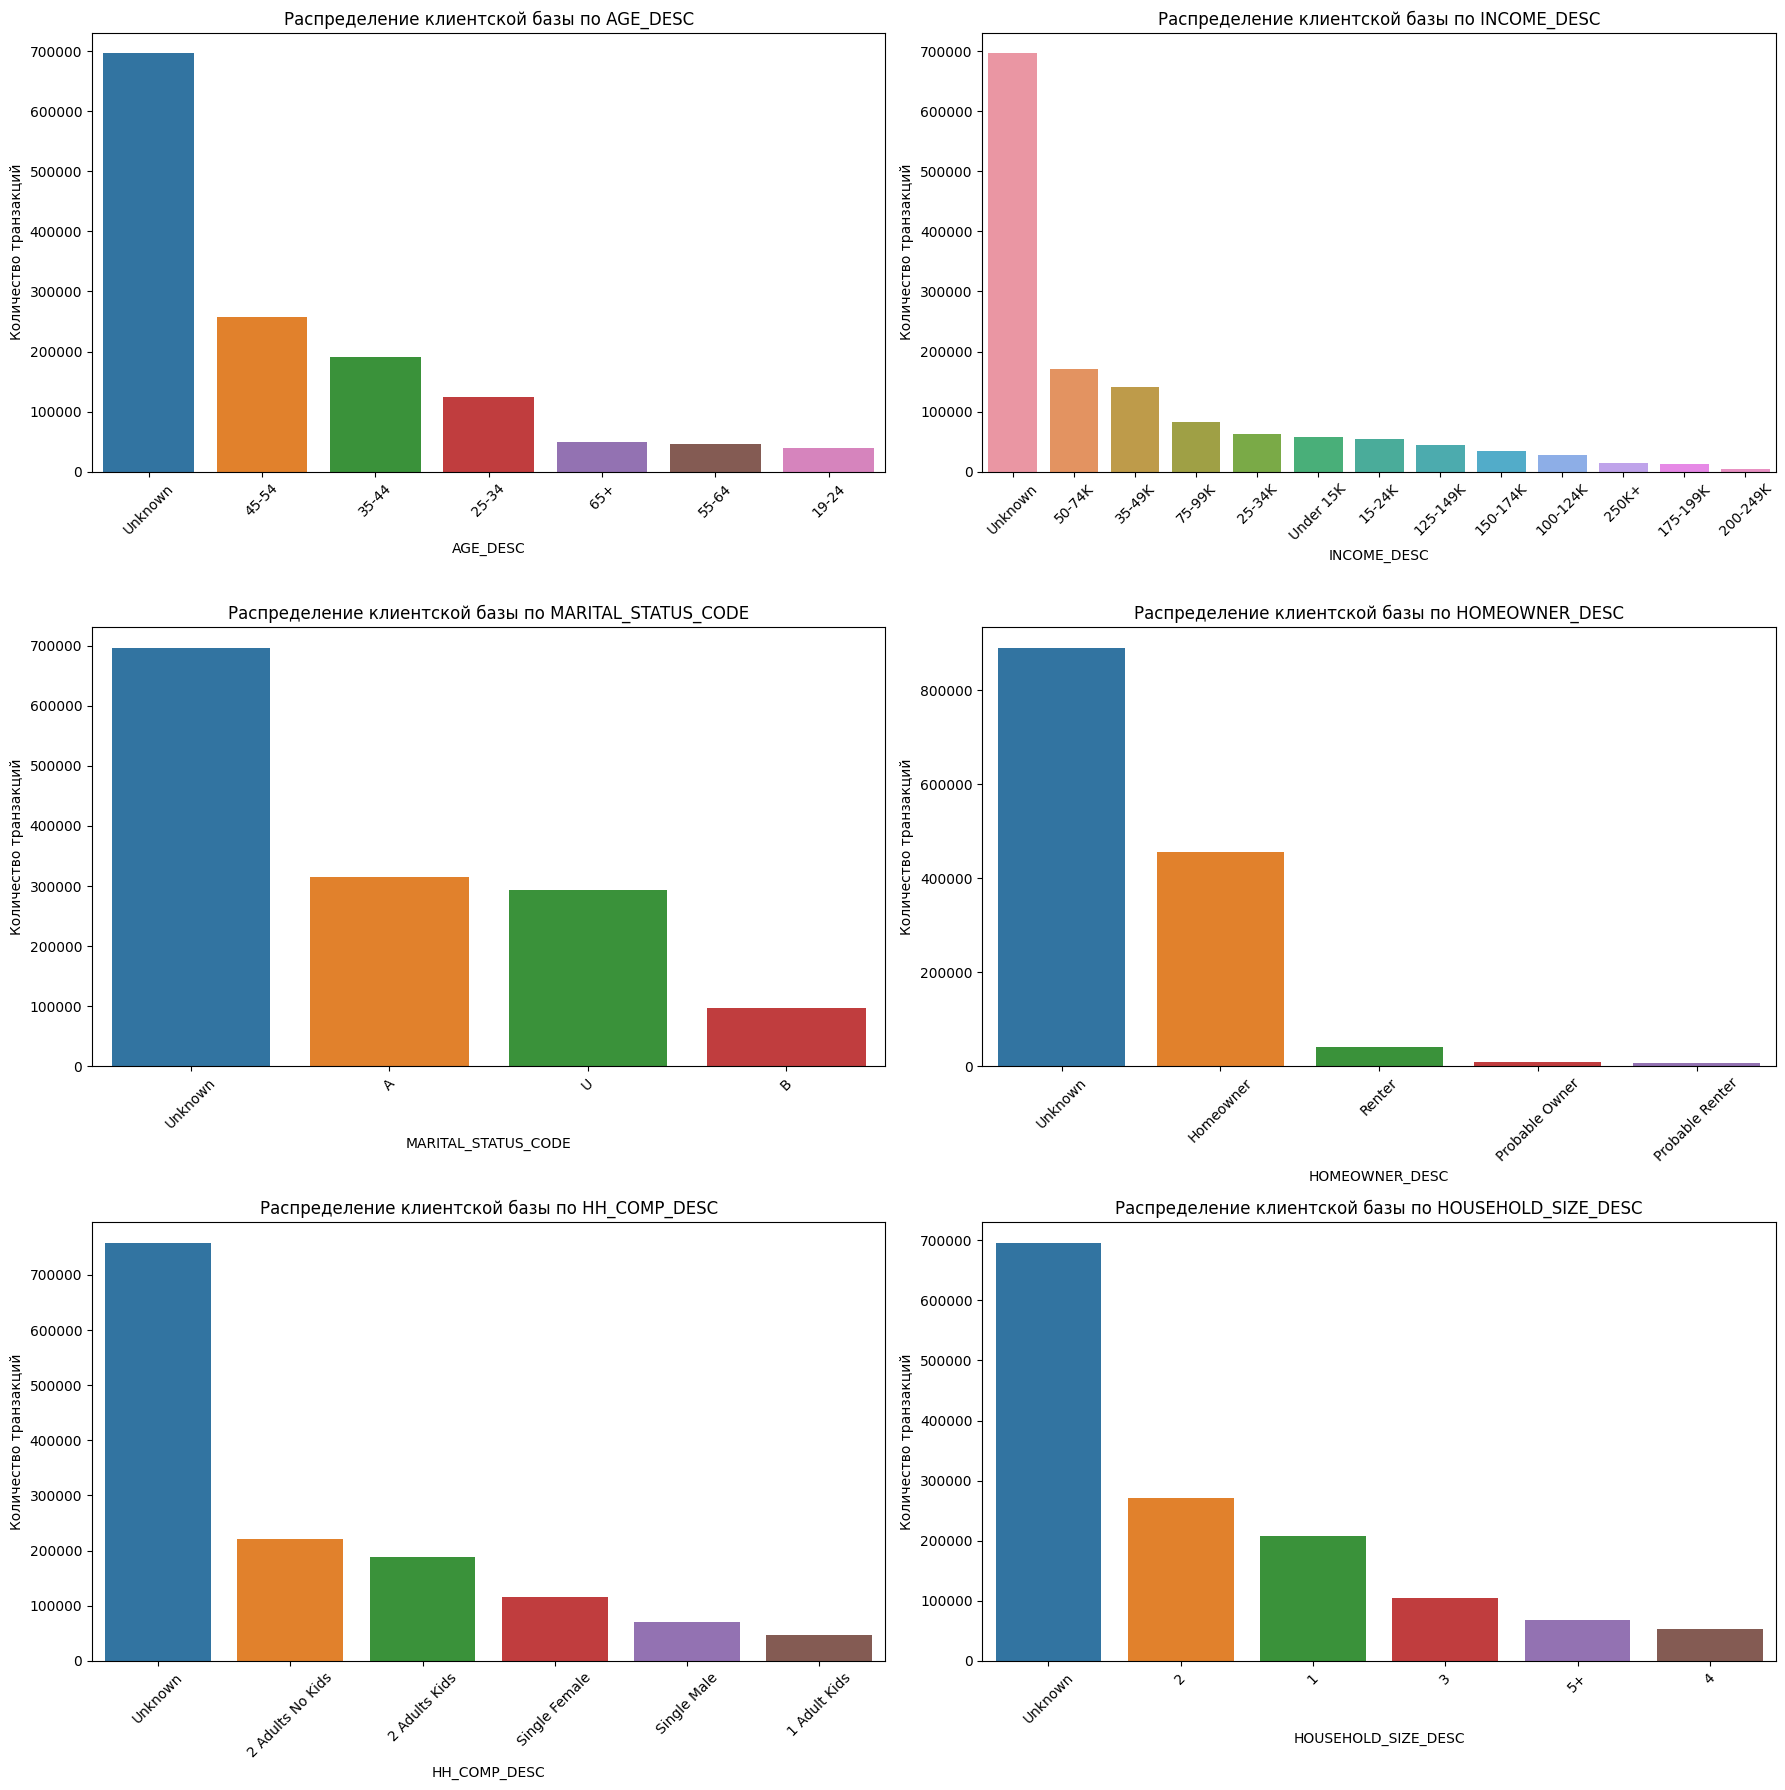

In [9]:
# Рисуем графики распределений по ключевым демографическим признакам
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
axes = axes.flatten()

demo_cols = ['AGE_DESC', 'INCOME_DESC', 'MARITAL_STATUS_CODE', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC']

for i, col in enumerate(demo_cols):
    sns.countplot(ax=axes[i], x=col, data=combined_data, order=combined_data[col].value_counts().index)
    axes[i].set_title(f"Распределение клиентской базы по {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Количество транзакций")
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

##### Анализ популярности категорий товаров #####

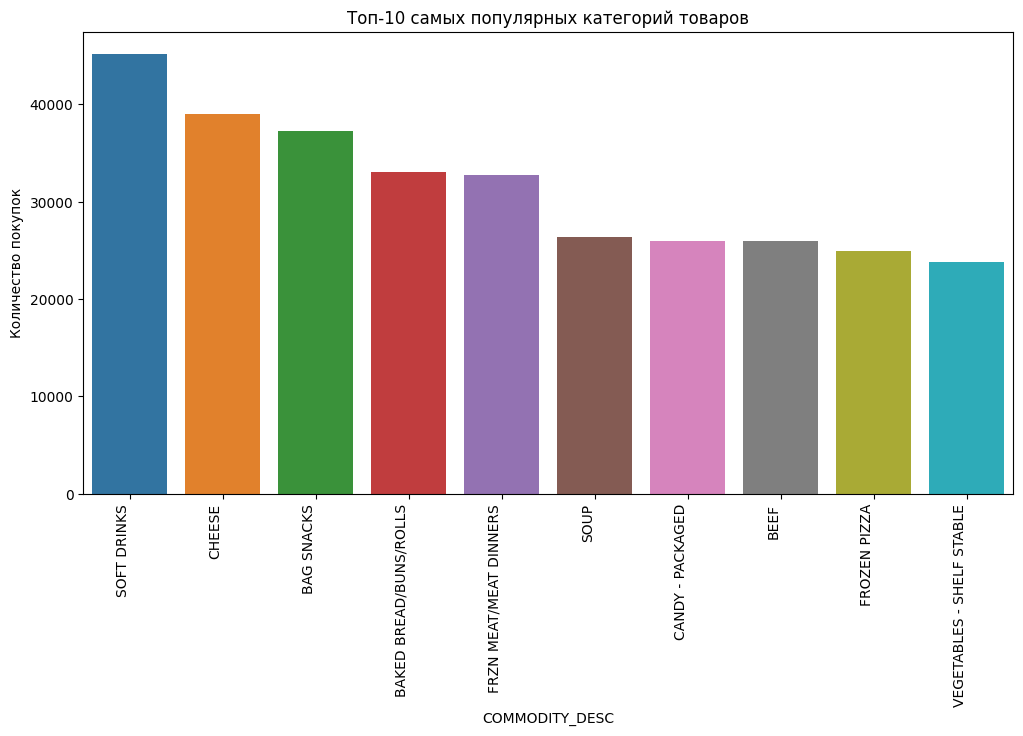

In [10]:
N = 10
plt.figure(figsize=(12, 6))
sns.countplot(data=combined_data, x="COMMODITY_DESC",
              order=combined_data["COMMODITY_DESC"].value_counts().head(N).index)
plt.title(f"Топ-{N} самых популярных категорий товаров")
plt.xlabel("COMMODITY_DESC")
plt.ylabel("Количество покупок")
plt.xticks(rotation=90, ha="right")
plt.show()

### Выводы ###
В данных очень много пропусков, однако удалять их нельзя, т.к. мы существенно потеряем в объеме данных по клиентам. В основном не размечены демографические признаки клиентов. Следственно, при анализе распределений мы видим доминирование "Unknown" во всех графиках. 
С этим можно и нужно работать, т.к. не размеченные дем.признаки не мешают формировать рекомендации для клиента, хотя и в ущерб качеству. 

### Этап 3: Baseline User-Based модель — Collaborative Filtering  ###
##### Мы строим простую модель на основе схожести пользователей. Она формирует рекомендации, основываясь на поведении похожих пользователей. #####

In [11]:
# Создаем матрицу взаимодействий
def create_interaction_matrix(df):
    interactions = (
        df.groupby(["household_key", "PRODUCT_ID"]).size().reset_index(name="frequency")
    )
    user_ids = interactions["household_key"].unique()
    product_ids = interactions["PRODUCT_ID"].unique()

    user_id_map = {user_id: i for i, user_id in enumerate(user_ids)}
    product_id_map = {product_id: i for i, product_id in enumerate(product_ids)}

    row_ind = interactions["household_key"].apply(lambda x: user_id_map[x])
    col_ind = interactions["PRODUCT_ID"].apply(lambda x: product_id_map[x])
    data = interactions["frequency"]

    interaction_matrix = csr_matrix(
        (data, (row_ind, col_ind)), shape=(len(user_ids), len(product_ids))
    )
    return interaction_matrix, user_id_map, product_id_map

In [12]:
# Сортируем данные по времени
combined_for_cf = combined_data.sort_values(by="DAY")

In [13]:
# Time-based split
train_size = int(0.8 * len(combined_for_cf))
train_df = combined_for_cf.iloc[:train_size]
test_df = combined_for_cf.iloc[train_size:]

In [14]:
# Генерируем матрицы
interaction_train, user_id_map_train, product_id_map_train = create_interaction_matrix(
    train_df
)
interaction_test, user_id_map_test, product_id_map_test = create_interaction_matrix(
    test_df
)

In [15]:
# Вычисляем сходства между пользователями
def calculate_user_similarity(matrix):
    return cosine_similarity(matrix)


user_similarity = calculate_user_similarity(interaction_train)

In [16]:
# Формирование рекомендации
def recommend_user_based(
    user_id,
    interaction_matrix,
    user_similarity,
    user_id_map,
    product_id_map,
    k=20,
    n=10,
):
    if user_id not in user_id_map:
        return []
    user_index = user_id_map[user_id]
    inverse_product_id_map = {i: pid for pid, i in product_id_map.items()}

    similar_users = np.argsort(user_similarity[user_index])[::-1][1 : k + 1]

    recommended_products = {}
    for idx in similar_users:
        bought_items = interaction_matrix[idx].nonzero()[1]
        for item in bought_items:
            pid = inverse_product_id_map[item]
            if pid not in recommended_products:
                recommended_products[pid] = 0
            recommended_products[pid] += 1

    bought_items = interaction_matrix[user_index].nonzero()[1]
    already_bought = [inverse_product_id_map[i] for i in bought_items]

    recommended_products = {
        k: v for k, v in recommended_products.items() if k not in already_bought
    }
    sorted_products = sorted(
        recommended_products.items(), key=lambda x: x[1], reverse=True
    )
    top_n_products = [p for p, _ in sorted_products[:n]]
    return top_n_products

In [17]:
# Оценка качества
def evaluate_recommendations(
    test_matrix,
    recommend_function,
    user_similarity,
    user_id_map,
    product_id_map,
    k=20,
    n=10,
):
    precisions = []
    recalls = []
    f_scores = []
    maps = []
    ndcgs = []
    hit_rates = []

    inverse_user_id_map = {i: user_id for user_id, i in user_id_map.items()}
    inverse_product_id_map = {i: product_id for product_id, i in product_id_map.items()}

    for user_index in range(test_matrix.shape[0]):
        user_id = inverse_user_id_map.get(user_index, None)
        if user_id is None:
            continue

        relevant_products = test_matrix[user_index].nonzero()[1]
        relevant_products = [inverse_product_id_map[i] for i in relevant_products]

        recommended_products = recommend_function(
            user_id,
            interaction_train,
            user_similarity,
            user_id_map,
            product_id_map,
            k,
            n,
        )
        if not relevant_products or not recommended_products:
            continue

        num_relevant = len(set(recommended_products).intersection(relevant_products))
        precision = num_relevant / len(recommended_products)
        recall = num_relevant / len(relevant_products)
        f_score = (
            2 * (precision * recall) / (precision + recall)
            if precision + recall > 0
            else 0.0
        )

        avg_precision = 0.0
        num_rel = 0
        for i in range(min(n, len(recommended_products))):
            if recommended_products[i] in relevant_products:
                num_rel += 1
                avg_precision += num_rel / (i + 1)
        map_score = (
            avg_precision / max(1, len(relevant_products))
            if len(relevant_products) > 0
            else 0.0
        )

        try:
            y_true = np.zeros(len(recommended_products))
            for i, p in enumerate(recommended_products):
                if p in relevant_products:
                    y_true[i] = 1
            y_pred = np.linspace(1, 0, len(recommended_products))
            ndcg = ndcg_score([y_true], [y_pred], k=n)
        except:
            ndcg = np.nan

        hit_rate = 1 if num_relevant > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f_scores.append(f_score)
        maps.append(map_score)
        ndcgs.append(ndcg)
        hit_rates.append(hit_rate)

    mean_precision = np.mean(precisions) if precisions else 0
    mean_recall = np.mean(recalls) if recalls else 0
    mean_f_score = np.mean(f_scores) if f_scores else 0
    mean_map = np.mean(maps) if maps else 0
    mean_ndcg = (
        np.mean([score for score in ndcgs if not np.isnan(score)])
        if any(not np.isnan(s) for s in ndcgs)
        else 0
    )
    mean_hit_rate = np.mean(hit_rates) if hit_rates else 0

    print(f"Mean Precision@{n}: {mean_precision:.4f}")
    print(f"Mean Recall@{n}: {mean_recall:.4f}")
    print(f"Mean F-score@{n}: {mean_f_score:.4f}")
    print(f"Mean MAP@{n}: {mean_map:.4f}")
    print(f"Mean NDCG@{n}: {mean_ndcg:.4f}")
    print(f"Mean Hit Rate@{n}: {mean_hit_rate:.4f}")

    return {
        "precision": mean_precision,
        "recall": mean_recall,
        "f_score": mean_f_score,
        "map": mean_map,
        "ndcg": mean_ndcg,
        "hit_rate": mean_hit_rate,
    }

In [18]:
print("\nUser-Based Collaborative Filtering - Personalized Recommendations (K=20):")
baseline_metrics = evaluate_recommendations(
    interaction_test,
    recommend_user_based,
    user_similarity,
    user_id_map_train,
    product_id_map_train,
    k=20,
    n=10,
)


User-Based Collaborative Filtering - Personalized Recommendations (K=20):
Mean Precision@10: 0.0147
Mean Recall@10: 0.0011
Mean F-score@10: 0.0019
Mean MAP@10: 0.0003
Mean NDCG@10: 0.0614
Mean Hit Rate@10: 0.1303


### Этап 4: Усложнённая модель — XGBoost Ranker  ###
##### Для улучшения рекомендаций я решил использовать более сложную модель на основе градиентного бустинга. 
##### Модель XGBRanker умеет работать с ранжированием, что подходит для задачи персонализированных рекомендаций.

In [19]:
# Игнорируем ошибки
warnings.filterwarnings('ignore')

In [20]:
# Проверяем доступность GPU и инициалиируемся
print("Инициализация...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используется устройство: {device.upper()}")
torch.manual_seed(42)
np.random.seed(42)

Инициализация...
Используется устройство: CUDA


In [21]:
# Функция загрузки и подготовки данных
def load_and_prepare_data(df):
    print("Загрузка и подготовка данных")

    required_cols = [
        "household_key",
        "PRODUCT_ID",
        "QUANTITY",
        "DEPARTMENT",
        "BRAND",
        "COMMODITY_DESC",
        "AGE_DESC",
        "INCOME_DESC",
        "HOMEOWNER_DESC",
        "DAY",
    ]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Отсутствуют необходимые колонки: {missing_cols}")

    df = df.copy()
    for col in [
        "DEPARTMENT",
        "BRAND",
        "COMMODITY_DESC",
        "AGE_DESC",
        "INCOME_DESC",
        "HOMEOWNER_DESC",
    ]:
        if col in df.columns:
            df[col] = df[col].astype("category")
            if "UNKNOWN" not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories("UNKNOWN")
            df[col] = df[col].fillna("UNKNOWN")

    return df

In [22]:
# Обогощаем данные фичами
def enrich_features(df):
    print("Обогащение фичей")

    # Сколько раз пользователь покупал этот товар
    df["user_item_count"] = df.groupby(["user_id", "item_id"])["QUANTITY"].transform(
        "sum"
    )

    # Популярность товара (сколько пользователей его купило)
    item_popularity = df.groupby("item_id")["user_id"].nunique()
    df["item_popularity"] = df["item_id"].map(item_popularity)

    # Частота покупок категории пользователем
    df["category_user_freq"] = df.groupby(["user_id", "COMMODITY_DESC"])[
        "QUANTITY"
    ].transform("sum")

    # Частота покупок бренда пользователем
    df["brand_user_freq"] = df.groupby(["user_id", "BRAND"])["QUANTITY"].transform(
        "sum"
    )

    # Ранг товара по частоте покупки им
    df["item_user_rank"] = df.groupby("user_id")["user_item_count"].rank(
        method="first", ascending=False
    )

    return df

In [23]:
# Энкодим фичи
def encode_features(df):
    print("Кодирование фичей")

    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    df["user_id"] = user_encoder.fit_transform(df["household_key"])
    df["item_id"] = item_encoder.fit_transform(df["PRODUCT_ID"])

    encoders = {"user": user_encoder, "item": item_encoder}
    return df, encoders

In [24]:
# Создаем фичи товаров
def create_item_features(df):
    print("Создание фичей товаров")

    item_features = df[
        ["item_id", "DEPARTMENT", "BRAND", "COMMODITY_DESC"]
    ].drop_duplicates()

    hasher = HashingVectorizer(n_features=50, alternate_sign=False)
    text_data = (
        item_features["DEPARTMENT"].astype(str)
        + " "
        + item_features["BRAND"].astype(str)
        + " "
        + item_features["COMMODITY_DESC"].astype(str)
    )
    text_features = hasher.fit_transform(text_data)

    svd = TruncatedSVD(n_components=15, random_state=42)
    item_features_reduced = svd.fit_transform(text_features)

    item_features_full = pd.DataFrame(
        item_features_reduced,
        index=item_features["item_id"],
        columns=[f"item_f{i}" for i in range(item_features_reduced.shape[1])],
    )

    return item_features_full, hasher, svd

In [25]:
# Создаем фичи пользователей
def create_user_features(df):
    print("Создание фичей пользователей")

    user_features = df[
        ["user_id", "AGE_DESC", "INCOME_DESC", "HOMEOWNER_DESC"]
    ].drop_duplicates()

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    user_features_ohe = ohe.fit_transform(
        user_features[["AGE_DESC", "INCOME_DESC", "HOMEOWNER_DESC"]]
    )

    feature_names = ohe.get_feature_names_out(
        ["AGE_DESC", "INCOME_DESC", "HOMEOWNER_DESC"]
    )

    user_features_full = pd.DataFrame(
        user_features_ohe, index=user_features["user_id"], columns=feature_names
    )

    return user_features_full, ohe

In [26]:
# Подготовка данных для обучения
def prepare_training_data(df, user_features, item_features):
    print("Подготовка данных для обучения")

    df = enrich_features(df)

    # Сортируем по времени перед разбиением
    df = df.sort_values(by="DAY")

    user_items = df.groupby("user_id")["item_id"].apply(list).to_dict()
    user_targets = df.groupby("user_id")["QUANTITY"].apply(list).to_dict()

    X, y, groups = [], [], []

    for user_id, items in user_items.items():
        user_feat = user_features.loc[user_id].values
        item_feat = item_features.loc[items].values

        group_df = df[df["user_id"] == user_id]
        extra_features = group_df[
            [
                "user_item_count",
                "item_popularity",
                "category_user_freq",
                "brand_user_freq",
                "item_user_rank",
            ]
        ].values

        user_feat_repeated = np.tile(user_feat, (len(items), 1))
        combined_features = np.hstack([user_feat_repeated, item_feat, extra_features])

        X.extend(combined_features)
        y.extend(group_df["QUANTITY"].values)
        groups.append(len(items))

    X = np.array(X)
    y = np.array(y)
    groups = np.array(groups)

    # Преобразуем таргет в целые числа
    y = np.clip(np.log1p(y), 0, 10)  # Логарифмируем и обрезаем
    y = y.astype(int)

    # Time-based split: последние 20% как тест
    test_size = int(0.2 * len(groups))
    train_indices = np.arange(len(groups) - test_size)
    test_indices = np.arange(len(groups) - test_size, len(groups))

    def stack_group_data(indices):
        starts = np.cumsum([0] + list(groups[indices]))
        X_grouped = np.vstack(
            [X[starts[i] : starts[i + 1]] for i in range(len(indices))]
        )
        y_grouped = np.hstack(
            [y[starts[i] : starts[i + 1]] for i in range(len(indices))]
        )
        return X_grouped, y_grouped, groups[indices]

    X_train, y_train, train_groups = stack_group_data(train_indices)
    X_test, y_test, test_groups = stack_group_data(test_indices)

    print(f"Данные подготовлены:")
    print(f"- Train: {X_train.shape[0]} samples, {len(train_groups)} users")
    print(f"- Test: {X_test.shape[0]} samples, {len(test_groups)} users")

    return X_train, X_test, y_train, y_test, train_groups, test_groups

In [27]:
# Оценка модели
def evaluate_model(model, X_test, y_test, test_groups, k=10):
    predictions = model.predict(X_test)

    precision_scores = []
    recall_scores = []
    f_score_scores = []
    map_scores = []
    ndcg_scores = []
    hit_rates = []

    start_idx = 0
    for group_size in test_groups:
        end_idx = start_idx + group_size
        y_true = y_test[start_idx:end_idx]
        y_pred = predictions[start_idx:end_idx]

        # Бинаризуем релевантность: > 0 значит релевантный товар
        relevant = y_true > 0

        effective_k = min(k, len(y_true))
        top_k = np.argsort(-y_pred)[:effective_k]

        pred_relevant = relevant[top_k]
        precision = pred_relevant.sum() / effective_k if effective_k > 0 else 0

        actual_relevant_count = relevant.sum()
        recall = (
            pred_relevant.sum() / max(1, actual_relevant_count)
            if actual_relevant_count > 0
            else 0
        )

        if precision + recall > 0:
            f_score = 2 * precision * recall / (precision + recall)
        else:
            f_score = 0.0

        avg_precision = 0.0
        num_rel = 0
        for i in range(effective_k):
            if relevant[top_k[i]]:
                num_rel += 1
                avg_precision += num_rel / (i + 1)
        map_score = (
            avg_precision / max(1, actual_relevant_count)
            if actual_relevant_count > 0
            else 0.0
        )

        try:
            ndcg = ndcg_score([y_true], [y_pred], k=effective_k)
        except:
            ndcg = np.nan

        hit_rate = 1 if pred_relevant.any() else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        f_score_scores.append(f_score)
        map_scores.append(map_score)
        ndcg_scores.append(ndcg)
        hit_rates.append(hit_rate)

        start_idx = end_idx

    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f_score = np.mean(f_score_scores)
    mean_map = np.mean(map_scores)
    mean_ndcg = np.mean([score for score in ndcg_scores if not np.isnan(score)])
    mean_hit_rate = np.mean(hit_rates)

    print("Метрики качества:")
    print(f"Mean Precision@{k}: {mean_precision:.4f}")
    print(f"Mean Recall@{k}: {mean_recall:.4f}")
    print(f"Mean F-score@{k}: {mean_f_score:.4f}")
    print(f"Mean MAP@{k}: {mean_map:.4f}")
    print(f"Mean NDCG@{k}: {mean_ndcg:.4f}")
    print(f"Mean Hit Rate@{k}: {mean_hit_rate:.4f}")

    return {
        "precision": mean_precision,
        "recall": mean_recall,
        "f_score": mean_f_score,
        "map": mean_map,
        "ndcg": mean_ndcg,
        "hit_rate": mean_hit_rate,
    }

In [28]:
# Поиск гиперпараметров и поиск оптимальных параметров для модели
def tune_model(
    X_train, y_train, train_groups, n_iter=5, early_stopping_rounds=20, cv=3
):
    print("Настройка гиперпараметров")

    param_dist = {
        "n_estimators": randint(100, 300),
        "max_depth": randint(4, 10),
        "learning_rate": uniform(0.01, 0.1),
        "subsample": uniform(0.7, 0.3),
        "colsample_bytree": uniform(0.7, 0.3),
    }

    base_model = XGBRanker(
        objective="rank:ndcg",
        tree_method="hist",
        device="cuda" if torch.cuda.is_available() else "cpu",
        eval_metric="ndcg@10",
        early_stopping_rounds=early_stopping_rounds,
        ndcg_exp_gain=False,
        random_state=42,
    )

    param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))
    cv_splitter = KFold(
        n_splits=cv, shuffle=False, random_state=None
    )  # НЕ перемешиваем!

    best_score = -np.inf
    best_params = None
    best_model = None

    for params in tqdm(param_list, desc="Перебор параметров"):
        model_scores = []
        for fold, (train_idx, val_idx) in enumerate(
            cv_splitter.split(X_train, y_train)
        ):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            # Восстанавливаем группы
            group_tr = []
            start = 0
            for g in train_groups:
                end = start + g
                mask = np.arange(start, end)
                overlap = np.intersect1d(mask, train_idx)
                if len(overlap) > 0:
                    group_tr.append(len(overlap))
                start = end

            group_val = []
            start = 0
            for g in train_groups:
                end = start + g
                mask = np.arange(start, end)
                overlap = np.intersect1d(mask, val_idx)
                if len(overlap) > 0:
                    group_val.append(len(overlap))
                start = end

            assert sum(group_tr) == len(X_tr)
            assert sum(group_val) == len(X_val)

            model = base_model.set_params(**params)
            try:
                model.fit(
                    X_tr,
                    y_tr,
                    group=group_tr,
                    eval_set=[(X_val, y_val)],
                    eval_group=[group_val],
                    verbose=False,
                )

                preds = model.predict(X_val)
                scores = []
                start_idx = 0
                for g in group_val:
                    end_idx = start_idx + g
                    y_true = y_val[start_idx:end_idx]
                    y_pred = preds[start_idx:end_idx]
                    if len(y_true) >= 10:
                        score = ndcg_score([y_true], [y_pred], k=10)
                        scores.append(score)
                    start_idx = end_idx
                fold_score = np.mean(scores) if scores else 0
                model_scores.append(fold_score)
            except Exception as e:
                print(f"Ошибка с параметрами {params} на фолде {fold}: {str(e)}")
                model_scores.append(-np.inf)

        avg_score = np.mean(model_scores)
        print(f"Params: {params} → Score: {avg_score:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_params = params
            best_model = model

    print("Лучшие параметры:", best_params)
    print("Лучший NDCG@10 на валидации:", best_score)
    return best_model

In [29]:
# Вспомогательная функция для оценки
def custom_scorer(model, X, y, groups):
    preds = model.predict(X)
    unique_groups = np.unique(groups)
    scores = []

    start_idx = 0
    for g in unique_groups:
        end_idx = start_idx + g
        y_true = y[start_idx:end_idx]
        y_pred = preds[start_idx:end_idx]
        if len(y_true) >= 10:
            score = ndcg_score([y_true], [y_pred], k=10)
            scores.append(score)
        start_idx = end_idx
    return np.mean(scores) if scores else 0

In [30]:
# Главный пайплайн
# Главный пайплайн
def main_pipeline(df):
    try:
        df = load_and_prepare_data(df)
        df, encoders = encode_features(df)
        item_features, hasher, svd = create_item_features(df)
        user_features, ohe = create_user_features(df)

        # Добавляем признаки в исходный датафрейм
        df = enrich_features(df)

        X_train, X_test, y_train, y_test, train_groups, test_groups = (
            prepare_training_data(df, user_features, item_features)
        )

        best_model = tune_model(X_train, y_train, train_groups)
        metrics = evaluate_model(best_model, X_test, y_test, test_groups)

        # Сохранение модели
        with open("xgb_ranker_model.pkl", "wb") as f:
            pickle.dump(best_model, f)

        # Возвращаем все нужные объекты
        return {
            "model": best_model,
            "metrics": metrics,
            "user_features": user_features,
            "item_features": item_features,
            "encoders": encoders,
            "ohe": ohe,
            "hasher": hasher,
            "svd": svd,
            "enriched_df": df 
        }

    except Exception as e:
        print(f"Ошибка в пайплайне: {str(e)}")
        raise

In [31]:
# Запуск пайплайна и сохранение результатов в перемененную
pipeline_results = main_pipeline(combined_data)
advanced_metrics = pipeline_results['metrics']

# Сохраняем важные переменные из пайплайна
user_features_full = pipeline_results['user_features']
item_features_full = pipeline_results['item_features']
encoders = pipeline_results['encoders']

Загрузка и подготовка данных
Кодирование фичей
Создание фичей товаров
Создание фичей пользователей
Обогащение фичей
Подготовка данных для обучения
Обогащение фичей
Данные подготовлены:
- Train: 1099643 samples, 2000 users
- Test: 301826 samples, 500 users
Настройка гиперпараметров


Перебор параметров:  20%|██        | 1/5 [03:07<12:30, 187.54s/it]

Params: {'colsample_bytree': 0.8123620356542087, 'learning_rate': 0.10507143064099161, 'max_depth': 6, 'n_estimators': 171, 'subsample': 0.8795975452591109} → Score: 0.9980


Перебор параметров:  40%|████      | 2/5 [06:10<09:15, 185.12s/it]

Params: {'colsample_bytree': 0.7468055921327309, 'learning_rate': 0.025599452033620268, 'max_depth': 6, 'n_estimators': 187, 'subsample': 0.8001125833417065} → Score: 0.9963


Перебор параметров:  60%|██████    | 3/5 [09:18<06:12, 186.32s/it]

Params: {'colsample_bytree': 0.7428600453765822, 'learning_rate': 0.07508884729488528, 'max_depth': 8, 'n_estimators': 101, 'subsample': 0.9165996316800473} → Score: 0.9975


Перебор параметров:  80%|████████  | 4/5 [12:24<03:06, 186.04s/it]

Params: {'colsample_bytree': 0.981565812704725, 'learning_rate': 0.010077876584101433, 'max_depth': 7, 'n_estimators': 120, 'subsample': 0.8852444528883149} → Score: 0.9947


Перебор параметров: 100%|██████████| 5/5 [15:26<00:00, 185.34s/it]

Params: {'colsample_bytree': 0.8834959481464842, 'learning_rate': 0.01070663052197174, 'max_depth': 4, 'n_estimators': 148, 'subsample': 0.8574323980775167} → Score: 0.9965
Лучшие параметры: {'colsample_bytree': 0.8123620356542087, 'learning_rate': 0.10507143064099161, 'max_depth': 6, 'n_estimators': 171, 'subsample': 0.8795975452591109}
Лучший NDCG@10 на валидации: 0.9980091936581035


Метрики качества:
Mean Precision@10: 0.9908
Mean Recall@10: 0.1244
Mean F-score@10: 0.1814
Mean MAP@10: 0.1244
Mean NDCG@10: 0.9861
Mean Hit Rate@10: 1.0000


### Финальный этап: Анализ результатов ###

In [32]:
# Выводим значения для проверки
print("\nМетрики усложнённой модели:")
for metric, value in advanced_metrics.items():
    print(f"{metric}: {value:.4f}")


Метрики усложнённой модели:
precision: 0.9908
recall: 0.1244
f_score: 0.1814
map: 0.1244
ndcg: 0.9861
hit_rate: 1.0000


In [33]:
# Создаём табличку для сравнения
comparison_df = pd.DataFrame({
    'Baseline': baseline_metrics,
    'Advanced': advanced_metrics
})

# Выводим таблицу
print("\nСравнение метрик моделей:")
comparison_df


Сравнение метрик моделей:


,Baseline,Advanced
precision,0.014703,0.990800
recall,0.001123,0.124386
f_score,0.001949,0.181388
map,0.000347,0.124386
ndcg,0.061400,0.986085
hit_rate,0.130267,1.000000


### Выгрузка рекомендаций для каждого пользователя

In [34]:
def recommend_for_user(user_id, model, df, user_features, item_features, encoders, top_n=10):

    # Получаем закодированный ID пользователя
    user_encoder = encoders["user"]
    item_encoder = encoders["item"]

    if user_id not in user_encoder.classes_:
        print(f"Пользователь {user_id} не найден в обучающих данных.")
        return []

    encoded_user_id = user_encoder.transform([user_id])[0]

    # Получаем список всех возможных товарных ID
    all_items = item_features.index.values  # item_id (закодированные)

    # Повторяем данные пользователя под каждый товар
    user_feat = user_features.loc[encoded_user_id].values
    user_feat_repeated = np.tile(user_feat, (len(all_items), 1))

    # Берём фичи товаров
    item_feat = item_features.loc[all_items].values

    # Простые дополнительные фичи
    dummy_count = np.zeros((len(all_items), 1))
    dummy_popularity = df['item_popularity'].mean()
    item_popularity = np.full((len(all_items), 1), dummy_popularity)

    extra_features = np.hstack([
        dummy_count,
        item_popularity,
        dummy_count,  # category_user_freq
        dummy_count,  # brand_user_freq
        np.arange(1, len(all_items) + 1).reshape(-1, 1)  # item_user_rank
    ])

    # Комбинируем все фичи
    combined_features = np.hstack([user_feat_repeated, item_feat, extra_features])

    # Предсказываем релевантность
    predictions = model.predict(combined_features)

    # Получаем индексы топ-N товаров
    top_item_indices = np.argsort(predictions)[::-1][:top_n]
    recommended_encoded_ids = all_items[top_item_indices]

    # Преобразуем в оригинальные ID
    recommended_product_ids = item_encoder.inverse_transform(recommended_encoded_ids)

    return recommended_product_ids

In [35]:
def generate_recommendation_table(
    model, 
    combined_data, 
    user_features_full, 
    item_features_full, 
    encoders, 
    top_n=10
):
    unique_users = combined_data['household_key'].unique()

    results = []

    for user_id in tqdm(unique_users, desc="Формирование рекомендаций"):
        recommendations = recommend_for_user(
            user_id=user_id,
            model=model,
            df=combined_data,
            user_features=user_features_full,
            item_features=item_features_full,
            encoders=encoders,
            top_n=top_n
        )

        # Получаем демографические данные пользователя
        user_row = combined_data[combined_data['household_key'] == user_id].iloc[0]

        result_row = {
            'household_key': user_id
        }

        # Добавляем характеристики пользователя
        demo_cols = ['AGE_DESC', 'INCOME_DESC', 'MARITAL_STATUS_CODE', 'HOMEOWNER_DESC',
                     'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC']
        for col in demo_cols:
            result_row[col] = user_row[col]

        # Добавляем рекомендации
        for i, product_id in enumerate(recommendations):
            result_row[f'rec_{i+1}'] = product_id

        results.append(result_row)

    # Создаём финальный DataFrame
    recommendations_df = pd.DataFrame(results)
    return recommendations_df

In [36]:
# Загружаем модель из файла
with open("xgb_ranker_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Генерируем таблицу рекомендаций для всех пользователей
recommendations_df = generate_recommendation_table(
    model=pipeline_results['model'],
    combined_data=pipeline_results['enriched_df'],
    user_features_full=user_features_full,
    item_features_full=item_features_full,
    encoders=encoders,
    top_n=10
)

# Сохраняем в CSV
recommendations_df.to_csv("recommendations_results.csv", index=False)

# Выводим на экран первые строки
print("Рекомендации успешно сформированы и выгружены:")
print(recommendations_df.head())

Формирование рекомендаций: 100%|██████████| 2500/2500 [03:14<00:00, 12.83it/s]


Рекомендации успешно сформированы и выгружены:
   household_key AGE_DESC INCOME_DESC MARITAL_STATUS_CODE HOMEOWNER_DESC  \
0              1      65+      35-49K                   A      Homeowner   
1              2  Unknown     Unknown             Unknown        Unknown   
2              3  Unknown     Unknown             Unknown        Unknown   
3              4  Unknown     Unknown             Unknown        Unknown   
4              5  Unknown     Unknown             Unknown        Unknown   

       HH_COMP_DESC HOUSEHOLD_SIZE_DESC KID_CATEGORY_DESC   rec_1   rec_2  \
0  2 Adults No Kids                   2      None/Unknown  821867  823721   
1           Unknown             Unknown           Unknown  821867  823721   
2           Unknown             Unknown           Unknown  821867  823721   
3           Unknown             Unknown           Unknown  821867  823721   
4           Unknown             Unknown           Unknown  821867  823721   

    rec_3   rec_4   rec_5   rec_6